In [1]:
#Basic libraries
import numpy as np
import pandas as pd
import gzip
import json
import sklearn

#NLTK libraries
import nltk
import re
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk.stem.porter import PorterStemmer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.stem.porter import *
from gensim import corpora, models
from gensim.models import word2vec
from bs4 import BeautifulSoup
import spacy 

#Visualization libraries
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
# %matplotlib inline

#ML libraries
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

#Metrics libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn import naive_bayes, linear_model, svm, ensemble

# Others
from collections import defaultdict
from collections import Counter
import pickle
import time
from os.path import join
from tqdm import tqdm
tqdm.pandas()
import warnings
warnings.filterwarnings('ignore')

/home/divyaj/.conda/envs/dl_exam/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/divyaj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/divyaj/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/divyaj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# !pip install -U spacy
# !python -m spacy download en_core_web_md, en_core_web_sm

en = spacy.load("en_core_web_md")

In [4]:
csv_path = '../Data/csv_files/'
reviews_df = pd.read_csv(csv_path + 'cleaned_reviews.csv')

In [5]:
reviews_df = reviews_df.fillna('')
reviews_df.head()

,reviewerID,asin,reviewText,summary,helpful,overall,reviewText_cleaned
0,ADZPIG9QOCDG5,0005019281,This is a charming version of the classic Dick...,good version of a classic,"[0, 0]",4.0,charming version classic dickens tale henry wi...
1,A35947ZP82G7JH,0005019281,It was good but not as emotionally moving as t...,Good but not as moving,"[0, 0]",3.0,good but not emotionally moving christmas caro...
2,A3UORV8A9D5L2E,0005019281,"Don't get me wrong, Winkler is a wonderful cha...",Winkler's Performance was ok at best!,"[0, 0]",3.0,dont get wrong winkler wonderful character act...
3,A1VKW06X1O2X7V,0005019281,Henry Winkler is very good in this twist on th...,It's an enjoyable twist on the classic story,"[0, 0]",5.0,henry winkler good twist classic story not con...
4,A3R27T4HADWFFJ,0005019281,This is one of the best Scrooge movies out. H...,Best Scrooge yet,"[0, 0]",4.0,one best scrooge movies henry winkler outdoes ...


In [6]:
reviews_df['combinedText'] = reviews_df['reviewText_cleaned'] + " " + reviews_df['summary']

In [7]:
def get_helpful_score(h_str):
    txt = h_str.split(",")
    val1 = txt[0].split("[")[1].strip()
    val2 = txt[1].split("]")[0].strip()
    try:
        res = int(val1) / int(val2)
    except ZeroDivisionError:
        res = 0
    return res

reviews_df['helpful_rate'] = reviews_df['helpful'].apply(get_helpful_score)
reviews_df['helpful_rate'] = reviews_df['helpful_rate'].fillna(0)
reviews_df['helpful_rate'] = reviews_df['helpful_rate'].round(2)
reviews_df.drop(columns='helpful', inplace=True)

In [8]:
# Sentiment can be defined using the overall rating provided by the user
def sentiment_basedOn_rating(val):
    if val == 3.0:
        return "neu"
    elif val == 1.0 or val == 2.0:
        return "neg"
    elif val == 4.0 or val == 5.0:
        return "pos"
    else:
        return "none"
    
reviews_df['user_label'] = reviews_df['overall'].apply(sentiment_basedOn_rating)

In [9]:
lb = preprocessing.LabelEncoder()
reviews_df['user_label'] = lb.fit_transform(reviews_df['user_label'])
# pos - 2, neu - 1, neg = 0

In [13]:
# Run only once

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                          test_size = 0.2,
                                          random_state = 42)

print('Train : {0}, Test: {1}'.format(len(X_train), len(X_test)))

def get_wordVec_feature(text):
    feat = en(text).vector
    return feat

train_vecs = np.stack([get_wordVec_feature(review) for review in tqdm(X_train)])
del X_train
test_vecs = np.stack([get_wordVec_feature(review) for review in tqdm(X_test)])
del X_test

np.save('../Data/train_vecs.npy', train_vecs)
np.save('../Data/test_vecs.npy', test_vecs)

np.save('../Data/y_train.npy', y_train)
np.save('../Data/y_test.npy', y_test)


In [10]:
train_vecs = np.load('../Data/train_vecs.npy')
test_vecs = np.load('../Data/test_vecs.npy')
y_train = np.load('../Data/y_train.npy')
y_test = np.load('../Data/y_test.npy')

In [19]:
def train_model(classifier, classifier_type, train_features, train_labels, test_features, test_labels):
    print('Classifier : ', classifier_type)
    print("-----------------------------------\n")
    
    start_time = time.time()
    # fit the training data on classifier
    classifier.fit(train_features, train_labels)
    print("--- Time taken: %s seconds ---" % (time.time() - start_time))
    
    print("\n-----------------------------------\n")
    
def plot_metrics(model, X_test, y_test, clf_name):
    pred = model.predict(X_test)
    # Source : https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/
    cm = metrics.confusion_matrix(y_test, pred)

    print(classification_report(y_test, pred, target_names=lb.classes_))

    ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
    ax.set_xlabel('\nSentiment Label from ' + clf_name)
    ax.set_ylabel('Sentiment Label from user rating');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['neg', 'neu','pos'])
    ax.yaxis.set_ticklabels(['neg', 'neu','pos'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

In [17]:
# Naive Bayes
nb_clf = naive_bayes.GaussianNB()
train_model(nb_clf, 'Naive Bayes', train_vecs, y_train, test_vecs, y_test)
f = open('../Models/nb_clf.pickle', 'wb')
pickle.dump(nb_clf, f)
f.close()

# Logistic regression
lr_clf = linear_model.LogisticRegression()
train_model(lr_clf, 'Logistic Regression', train_vecs, y_train, test_vecs, y_test)
f = open('../Models/lr_clf.pickle', 'wb')
pickle.dump(lr_clf, f)
f.close()

# SVM
svm_clf = svm.LinearSVC()
train_model(svm_clf, 'SVM', train_vecs, y_train, test_vecs, y_test)
f = open('../Models/svm_clf.pickle', 'wb')
pickle.dump(svm_clf, f)
f.close()

              precision    recall  f1-score   support

         neg       0.27      0.54      0.36     41326
         neu       0.15      0.42      0.22     40260
         pos       0.87      0.49      0.63    257921

    accuracy                           0.49    339507
   macro avg       0.43      0.48      0.40    339507
weighted avg       0.71      0.49      0.55    339507



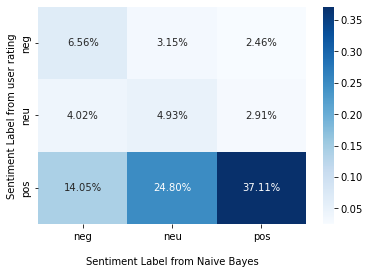

In [20]:
import pickle
f = open('../Models/nb_clf.pickle', 'rb')
nb_clf = pickle.load(f)
f.close()

plot_metrics(nb_clf, test_vecs, y_test, 'Naive Bayes')

              precision    recall  f1-score   support

         neg       0.58      0.32      0.41     41326
         neu       0.37      0.03      0.06     40260
         pos       0.80      0.97      0.88    257921

    accuracy                           0.78    339507
   macro avg       0.59      0.44      0.45    339507
weighted avg       0.72      0.78      0.72    339507



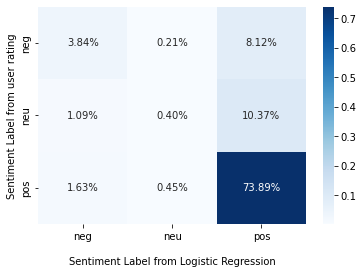

In [21]:
f = open('../Models/lr_clf.pickle', 'rb')
lr_clf = pickle.load(f)
f.close()

plot_metrics(lr_clf, test_vecs, y_test, 'Logistic Regression')

              precision    recall  f1-score   support

         neg       0.61      0.26      0.37     41326
         neu       0.46      0.01      0.02     40260
         pos       0.79      0.98      0.88    257921

    accuracy                           0.78    339507
   macro avg       0.62      0.42      0.42    339507
weighted avg       0.73      0.78      0.71    339507



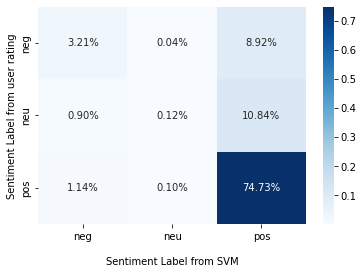

In [22]:
f = open('../Models/svm_clf.pickle', 'rb')
svm_clf = pickle.load(f)
f.close()

plot_metrics(svm_clf, test_vecs, y_test, 'SVM')